In [1]:
import models
import nndata
reload(nndata)
import numpy as np

Using TensorFlow backend.


## Basic crossvalidation

A basic performance crossvalidation for all subsets of the data with 2, 3, or 4 classes.

In [ ]:
from keras.callbacks import ModelCheckpoint

SPLITS = 5
input_length = 3 * 160 # = 3s
electrodes = range(64)
epochs = 3
epoch_steps = 5 # record performance 5 times per epoch
batch = 16
#nclasses = [2, 3, 4]
nclasses = [3]
#splits = range(5)
splits = [0]

results = np.zeros((len(nclasses), len(splits), 4, epochs*epoch_steps))
for j,nclasses in enumerate(nclasses):
    try:
        del X,y
    except:
        pass
    X,y = nndata.load_raw_data(electrodes=electrodes, num_classes=nclasses)
    
    steps_per_epoch = np.prod(X.shape[:2]) / batch * (1-1./SPLITS) / epoch_steps
    for ii,i in enumerate(splits):
        print "%d CLASS, SPLIT %d" % (nclasses, i)
        idx = range(len(X))
        train_idx, test_idx = nndata.split_idx(i, 5, idx)

        model = models.create_raw_model(
            nchan=len(electrodes), 
            nclasses=nclasses, 
            trial_length=input_length
        )        
        
        # save best weights for each model
        weights_path = "weights-%dcl-%d.hdf5" % (nclasses,i)
        checkpoint = [ModelCheckpoint(filepath=weights_path, save_best_only=True)]
        
        # run training
        h = models.fit_model(
            model, X, y, train_idx, test_idx, input_length=input_length, 
            batch_size=batch,  steps_per_epoch=steps_per_epoch, epochs=epochs*epoch_steps, 
            callbacks=checkpoint
        )

        # save training history
        results[j, ii, :, :] = [ 
            h.history["acc"], 
            h.history["loss"], 
            h.history["val_acc"], 
            h.history["val_loss"] 
        ]

## Subject retraining

Using pretrained weights, this procedure loops over all subjects and refines the parameters for each subject recording the new accuracy.

In [ ]:
SPLITS = 5

input_length = 3*160
electrodes = range(64)
classes = 2

X, y = nndata.load_raw_data(electrodes=electrodes, num_classes=classes)

weights_file = "weights-2cl-%d.hdf5"
model = models.create_raw_model(
    nchan=len(electrodes), 
    nclasses=classes, 
    trial_length=input_length
)

results = np.zeros((len(X), 2))

for split in range(5):
    idx = range(len(X))
    train_idx, test_idx = nndata.split_idx(split, SPLITS, idx)
    Xsub, ysub = nndata.crossval_test(X, y, test_idx, input_length, flatten=False)
    
    # for each subject in the training set
    for i, subject_X in enumerate(Xsub):
        current_subject = test_idx[i]
        subject_y = ysub[i,:]
        print current_subject,
        
        # accuracy without retraining
        model.load_weights(weights_file % (split))
        results[current_subject, 0] = model.evaluate(
            subject_X.reshape((-1,) + (input_length, len(electrodes), 1)), 
            subject_y.reshape((-1, classes)), verbose=0
        )[1]
        
        # retrain and validate on 4 subject splits
        epochs = 5
        temp_results = [] 
        for subject_split in range(4):
            trial_idx = range(len(subject_X))
            train_trials, test_trials = nndata.split_idx(subject_split, 4, trial_idx)

            model.load_weights(weights_file % (split))
            h = model.fit(
                subject_X[train_trials,:], subject_y[train_trials,:], 
                validation_data=(subject_X[test_trials,:], subject_y[test_trials,:]),
                epochs=5, batch_size=2, verbose=0
            )
            # save best validation accuracy
            temp_results.append(np.max(h.history["val_acc"]))
        results[current_subject, 1] = np.mean(temp_results)

## Input length crossvalidation

This code records the average accuracy with respect to the length of the input data.

In [ ]:
BATCH = 16
SPLITS = 5
electrodes = range(64)
classes = 3
X,y = nndata.load_raw_data(electrodes, num_classes=classes)

epochs = 3
splits = range(5)
steps_per_epoch = np.prod(X.shape[:2]) / BATCH * (1-1./SPLITS)

#lengths = np.arange(30, 160, 10) # short, less spacing
lengths = np.arange(160, 960, 40) # long, more spacing

results = np.zeros((len(lengths), len(splits), 4, epochs))
for ii,i in enumerate(splits):
    for j, length in enumerate(lengths):
        print "Length %d, SPLIT %d" % (length, i)
        idx = range(len(X))
        train_idx, test_idx = nndata.split_idx(i, 5, idx)
        model = models.create_raw_model(
            nchan=len(electrodes), 
            nclasses=classes, 
            trial_length=length
        )
        
        h = models.fit_model(
            model, X, y, train_idx, test_idx, 
            input_length=length, batch_size=BATCH, 
            steps_per_epoch=steps_per_epoch, epochs=epochs
        )
        
        results[j, ii, :, :] = [ 
            h.history["acc"], 
            h.history["loss"], 
            h.history["val_acc"], 
            h.history["val_loss"]
        ]

## Online evaluation

This code was used to determine the accuracy depending on the position of a data segment relative to the beginning of the MI trial.

In [ ]:
classes = 3
split = 0

step = 20
trial_length = 6*160
channels =  range(64)
# load model
model = models.create_raw_model(nchan=len(channels), nclasses=classes, trial_length=input_length)
model.load_weights("weights-%dcl-%d.hdf5" % (classes, split))

idx = range(len(X))
train_idx, test_idx = nndata.split_idx(split, 5, idx)
acc = np.zeros((trial_length-input_length)/ step + 1)
cert = np.zeros((trial_length-input_length)/ step + 1)
falsenull = np.zeros((trial_length-input_length)/ step + 1)
for i, off in enumerate(np.arange(0, trial_length-input_length, step)):
    print off, 
    xt,yt = nndata.crossval_test(X, y, test_idx, input_length, fix_offset=off)
    yp = model.predict(xt)
    cert[i] = yp[yt>0].mean()
    acc[i] = sum(yp.argmax(1)==yt.argmax(1)) / float(len(yt))
    if classes > 2:
        falsenull[i] = sum(yp[yt[:,2]==0].argmax(1)==2) / float(len(yt))
        
np.save("online-certainty.npy")
np.save("online-accuracy.npy")
if classes > 2:
    np.save("online-falsenull.npy")

## PCA of feature detector

This code was used to examine and visualize the principal components of the CNN feature detector.

In [ ]:
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import nndata
import models

input_length = 960
electrodes = range(64)
classes = [2,3,4]
split = 0 # select first split as example

weights_path = "weights-%dcl-0.hdf5" # make sure weights exist %d is a wildcard for number of classes

for cls in classes:
    X,y = nndata.load_raw_data(electrodes=electrodes, num_classes=cls)
    model = models.create_raw_model(nchan=len(electrodes), nclasses=cls, trial_length=input_length, l1=0)
    model.load_weights(weights_path % cls)
    
    # Define tensor function from input to fifth layer
    get_layer_output = K.function([model.layers[0].input], [model.layers[4].output])
    
    idx = range(len(X))
    train_idx, test_idx = nndata.split_idx(split, 5, idx)
    Xtest,ytest = nndata.crossval_test(X, y, test_idx, input_length)
    results = np.zeros((Xtest.shape[0], model.layers[4].output_shape[1]))
    for i, xtest in enumerate(Xtest):
        results[i,:] = get_layer_output([[xtest]])[0].reshape(-1)
    
    savemap = dict()
    savemap["output"] = results
    savemap["classes"] = ytest.argmax(1)
    savemap["classification"] = model.predict(Xtest).argmax(1)
    # save to file
    np.save("pca/%dclass.npy" % cls, savemap)

In [ ]:
# make sure previous section created these files
fnames = ["pca/2class.npy", "pca/3class.npy", "pca/4class.npy"]
markers = ["xr", "xb", "xg", "xk"]
plt.figure(figsize=(16,8))
for i, name in enumerate(fnames):
    m = np.load(name).item()
    results = m["output"]
    labels = m["classes"]
    
    pca = PCA(n_components=4)
    pca.fit(results)
    Xtrans = pca.transform(results)
    
    plt.subplot(1,3,i+1)
    for j in [0,1,2,3]:
        plt.plot(Xtrans[labels==j, 0], Xtrans[labels==j, 1], markers[j])
        
    plt.xlabel("PC 0")
    plt.ylabel("PC 1")
    print "File %s" % name,
    print "variance explained: %.2f %%" % (np.sum(pca.explained_variance_ratio_[:2])*100)

## Trained filters

In [2]:
import numpy as np
from scipy.signal import freqz
import math
import models
from matplotlib import pyplot as plt
from matplotlib2tikz import save as tikz_save

electrodes = range(64)
nclasses=3
input_length = 3 * 160

model = models.create_raw_model(
    nchan=len(electrodes), 
    nclasses=nclasses, 
    trial_length=input_length
)        
 
model.load_weights("weights-3cl-0.hdf5")

filters = model.get_weights()[0].reshape((30,40))

results = np.zeros((40,512))
for i in range(40):
    f = filters[:,i]
    freq, h = freqz(f,[1]) 
    results[i,:] = abs(h) ** 2
    
def mid_freq(row, freq):
    n = len(row)
    nrow = row/row.mean()
    return sum(np.multiply(nrow[:n/2+1],freq[:n/2+1]))


order = map(lambda r: mid_freq(r, freq), results)
idx_ordered = sorted(range(40), key=lambda v: order[v])

Using TensorFlow backend.


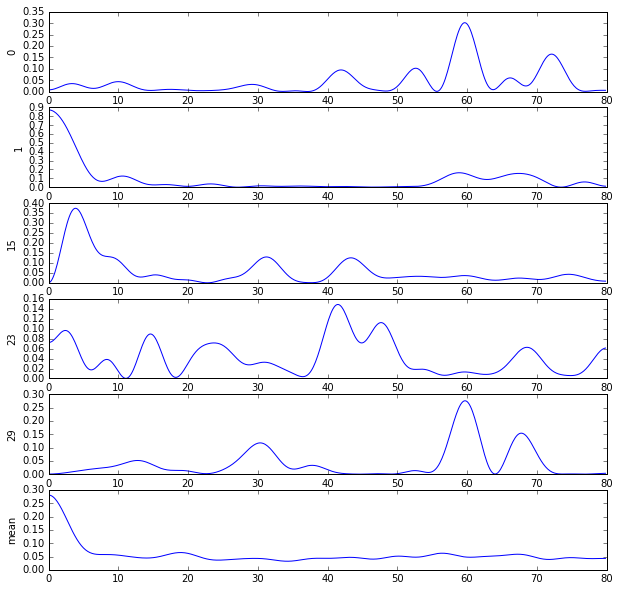

In [4]:
plt.figure(figsize=(10,10))
#selection = range(40)
selection = [0,1,15,23,29]
for i,s in enumerate(selection):
    plt.subplot(len(selection)+1,1,i+1)
    plt.plot(freq / math.pi * 80, results[idx_ordered[s]])
    #plt.ylabel("|H(f)_%d|^2" % s)
    plt.ylabel(s)
    #plt.ylim(0,0.6)
plt.subplot(len(selection)+1,1,len(selection)+1)
plt.plot(freq / math.pi * 80, results.mean(0))
plt.ylabel("mean")
#tikz_save("temporal_filters.tex")
pass

In [5]:
import numpy as np
import models
from scipy.signal import freqz
import math
from matplotlib import pyplot as plt
from matplotlib2tikz import save as tikz_save
import util 

electrodes = range(64)
nclasses=3
input_length = 3 * 160

model = models.create_raw_model(
    nchan=len(electrodes), 
    nclasses=nclasses, 
    trial_length=input_length
)        
 
model.load_weights("weights-3cl-0.hdf5")

idx = range(42) + range(44,63)

channels = model.get_weights()[2][0,idx,:,:].mean(2)
positions = util.projection_2d(util.get_physionet_electrode_positions())[idx,:]

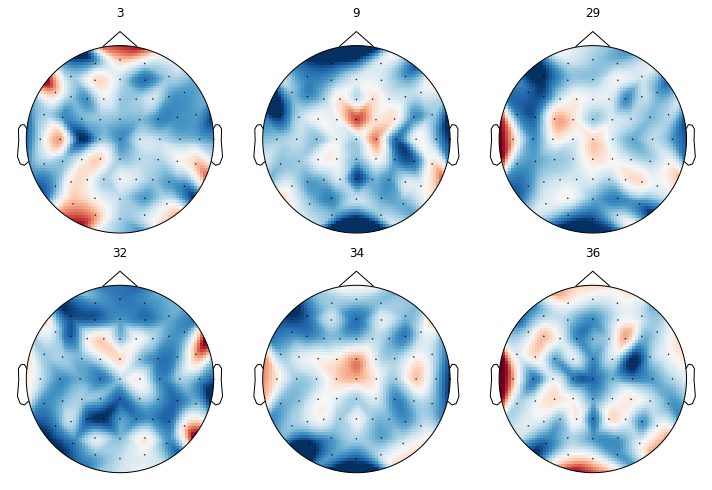

In [8]:
import mne
from matplotlib2tikz import save as save_tikz

#selection=[0,3,7,9,15,18,21,25,27,29,32,34,36,38,39]
selection=[3,9,29,32,34,36]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
for i,idx in enumerate(selection):
    ax = axes[i/3,i%3]
    ax.set_title(idx)
    mne.viz.plot_topomap(channels[:,idx], positions, show=False, axes=ax, contours=0, image_interp="nearest")

fig.tight_layout()
fig.savefig("foo.pdf", bbox_inches='tight')